In [1]:
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D
import math
import imageio
from skimage.transform import resize
from keras.models import Model
from glob import glob
import os.path
import scipy.misc
import numpy as np
import random
import matplotlib.pyplot as plt
from keras import optimizers
from keras.callbacks import ModelCheckpoint
import keras.backend as K

ImageDims = (160, 320)
DatasetDir = 'D:\OpenVINO\PH2'
RsltDir = 'D:\OpenVINO\\Res'
ImageExt = '.bmp'
batch_size = 5
ModelArch = 2

Using TensorFlow backend.


In [2]:
def generator(data_folder, image_shape, batch_size):
    ImagePaths = glob(os.path.join(data_folder, 'images', '*' + ImageExt))    
    label_paths = {
        os.path.basename(path): path
        for path in glob(os.path.join(DatasetDir, 'labels', '*' + ImageExt))}
    
    background_color = np.array([1.0, 1.0, 1.0])  ## Solo el blanco

    random.shuffle(ImagePaths)
    while 1: 
        for batch_i in range(0, len(ImagePaths), batch_size):
            images = []
            gt_images = []
            for image_file in ImagePaths[batch_i:batch_i+batch_size]:
                gt_image_file = label_paths[os.path.basename(image_file)]

                image = resize(imageio.imread(image_file), image_shape, mode='constant', anti_aliasing=False)
                gt_image = resize(imageio.imread(gt_image_file), image_shape, mode='constant', anti_aliasing=False)
                                
                if len(gt_image.shape) < 3:
                    x = np.zeros((gt_image.shape[0], gt_image.shape[1], 3))
                    x[:,:,1] = gt_image
                    x[:,:,2] = gt_image
                    x[:,:,0] = gt_image                    
                    gt_bg = np.all(x == background_color, axis = 2)  #Binarizar la segmentación del target
                else:
                    gt_bg = np.all(gt_image == background_color, axis = 2)  #Binarizar la segmentación del target
                
                gt_bg = gt_bg.reshape(*gt_bg.shape, 1)   # Añadirle una dimensión al tensor
                
                gt_image = np.concatenate((gt_bg, np.invert(gt_bg)), axis=2)  #crear dos capas reflejo
                
                images.append(image)
                gt_images.append(gt_image)
                
            X = np.array(images)
            Y = np.array(gt_images)
            yield (X, Y)
        
train_generator = generator(os.path.join(DatasetDir, 'training'), ImageDims, batch_size)
validation_generator = generator(os.path.join(DatasetDir, 'validation'), ImageDims, batch_size)      


In [3]:
def IOU_calc(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(K.clip(y_true_f + y_pred_f, 0, 1))
    return intersection/union

def IOU_calc_loss(y_true, y_pred):
    return -IOU_calc(y_true, y_pred)

In [4]:
def UNetFull(img_rows, img_cols, img_channels):  # 23 trainable layers, use same padding, en lugar de unpadding layers
    x = Input(shape=(img_rows, img_cols, img_channels))
    
    # Encoder 
    conv1 = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    conv2 = Conv2D(64, (3, 3), padding='same', activation='relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(128, (3, 3), padding='same', activation='relu')(pool1)
    conv4 = Conv2D(128, (3, 3), padding='same', activation='relu')(conv3)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    conv5 = Conv2D(256, (3, 3), padding='same', activation='relu')(pool2)
    conv6 = Conv2D(256, (3, 3), padding='same', activation='relu')(conv5)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv6)
    
    conv7 = Conv2D(512, (3, 3), padding='same', activation='relu')(pool3)
    conv8 = Conv2D(512, (3, 3), padding='same', activation='relu')(conv7)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv8)
    
    conv9 = Conv2D(1024, (3, 3), padding='same', activation='relu')(pool4)
    conv10 = Conv2D(1024, (3, 3), padding='same', activation='relu')(conv9)
    
    # Decoder
    convT1 = Conv2D(512, (2, 2), padding='same', activation='relu')(UpSampling2D(size=(2, 2))(conv10))
    merge1 = concatenate([convT1, conv8], axis=3)
    conv11 = Conv2D(512, (3, 3), padding='same', activation='relu')(merge1)
    conv12 = Conv2D(512, (3, 3), padding='same', activation='relu')(conv11)
    
    convT2 = Conv2D(256, (2, 2), padding='same', activation='relu')(UpSampling2D(size=(2, 2))(conv12))
    merge2 = concatenate([convT2, conv6], axis=3)
    conv13 = Conv2D(256, (3, 3), padding='same', activation='relu')(merge2)
    conv14 = Conv2D(256, (3, 3), padding='same', activation='relu')(conv13)
    
    convT3 = Conv2D(128, (2, 2), padding='same', activation='relu')(UpSampling2D(size=(2, 2))(conv14))
    merge3 = concatenate([convT3, conv4], axis=3)
    conv15 = Conv2D(128, (3, 3), padding='same', activation='relu')(merge3)
    conv16 = Conv2D(128, (3, 3), padding='same', activation='relu')(conv15)
    
    convT4 = Conv2D(64, (2, 2), padding='same', activation='relu')(UpSampling2D(size=(2, 2))(conv16))
    merge4 = concatenate([convT4, conv2], axis=3)
    conv17 = Conv2D(64, (3, 3), padding='same', activation='relu')(merge4)
    conv18 = Conv2D(64, (3, 3), padding='same', activation='relu')(conv17)

    y = Conv2D(2, (1, 1), activation='softmax')(conv18)

    return Model(inputs=x, outputs=y)

def UNetMedium(img_rows, img_cols, img_channels):  #lr = 0.0009
    x = Input(shape=(img_rows, img_cols, img_channels))
    
    # Encoder 
    conv1 = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    conv2 = Conv2D(64, (1, 1), padding='same', activation='relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(128, (3, 3), padding='same', activation='relu')(pool1)
    conv4 = Conv2D(128, (1, 1), padding='same', activation='relu')(conv3)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    conv5 = Conv2D(256, (3, 3), padding='same', activation='relu')(pool2)
    conv6 = Conv2D(256, (1, 1), padding='same', activation='relu')(conv5)
    
    # Decoder   
    convT1 = Conv2D(128, (2, 2), padding='same', activation='relu')(UpSampling2D(size=(2, 2))(conv6))
    merge1 = concatenate([convT1, conv4], axis=3)
    conv7 = Conv2D(128, (3, 3), padding='same', activation='relu')(merge1)
    conv8 = Conv2D(128, (1, 1), padding='same', activation='relu')(conv7)
    
    convT2 = Conv2D(64, (2, 2), padding='same', activation='relu')(UpSampling2D(size=(2, 2))(conv8))
    merge2 = concatenate([convT2, conv2], axis=3)
    conv9 = Conv2D(64, (3, 3), padding='same', activation='relu')(merge2)
    conv10 = Conv2D(64, (1, 1), padding='same', activation='relu')(conv9)  

    # Segmentation
    y = Conv2D(2, (1, 1), activation='softmax')(conv10)

    return Model(inputs=x, outputs=y)

def UNetSmall(img_rows, img_cols, img_channels):  #lr = 0.0009
    x = Input(shape=(img_rows, img_cols, img_channels))
    
    # Encoder 
    conv1 = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    conv2 = Conv2D(64, (1, 1), padding='same', activation='relu')(conv1)
    pool = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(128, (3, 3), padding='same', activation='relu')(pool)
    conv4 = Conv2D(128, (1, 1), padding='same', activation='relu')(conv3)
    
    # Decoder   
    convT = Conv2D(64, (2, 2), padding='same', activation='relu')(UpSampling2D(size=(2, 2))(conv4))
    merge = concatenate([convT, conv2], axis=3)
    conv5 = Conv2D(64, (3, 3), padding='same', activation='relu')(merge)
    conv6 = Conv2D(64, (1, 1), padding='same', activation='relu')(conv5)
    
    # Segmentation
    y = Conv2D(2, (1, 1), activation='softmax')(conv6)

    return Model(inputs=x, outputs=y)

In [5]:
Epochs = 50;
FileName = str(ModelArch) +'A_' + str(Epochs) + 'E_' + str(ImageDims[0]) + 'x' + str(ImageDims[1]) + 'D.h5'

if ModelArch == 0:
    model = UNetFull(ImageDims[0], ImageDims[1], 3)
elif ModelArch == 1:
    model = UNetMedium(ImageDims[0], ImageDims[1], 3)
else:
    model = UNetSmall(ImageDims[0], ImageDims[1], 3)

adam = optimizers.Adam(lr = 0.0009, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-08, decay = 0.0)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=[IOU_calc])
checkpointer = ModelCheckpoint(filepath = RsltDir + '\\' + FileName, monitor='val_loss', verbose=0, save_best_only=True,
                              mode = 'min', period = 1)

In [6]:
h = model.fit_generator(train_generator, steps_per_epoch=40, epochs = Epochs, verbose=1, callbacks=[checkpointer], 
                        validation_data=validation_generator, validation_steps=89//batch_size)

Epoch 1/50
40/40 [==============================] - 20s 508ms/step - loss: 0.5226 - IOU_calc: 0.4792 - val_loss: 0.4815 - val_IOU_calc: 0.4784
Epoch 2/50
40/40 [==============================] - 16s 388ms/step - loss: 0.4232 - IOU_calc: 0.5770 - val_loss: 0.3671 - val_IOU_calc: 0.6027
Epoch 3/50
40/40 [==============================] - 16s 388ms/step - loss: 0.3734 - IOU_calc: 0.6217 - val_loss: 0.3392 - val_IOU_calc: 0.6693
Epoch 4/50
40/40 [==============================] - 15s 387ms/step - loss: 0.3875 - IOU_calc: 0.6194 - val_loss: 0.3598 - val_IOU_calc: 0.6425
Epoch 5/50
40/40 [==============================] - 16s 391ms/step - loss: 0.3440 - IOU_calc: 0.6500 - val_loss: 0.3167 - val_IOU_calc: 0.6751
Epoch 6/50
40/40 [==============================] - 16s 390ms/step - loss: 0.3395 - IOU_calc: 0.6545 - val_loss: 0.2970 - val_IOU_calc: 0.6776
Epoch 7/50
40/40 [==============================] - 16s 391ms/step - loss: 0.3232 - IOU_calc: 0.6711 - val_loss: 0.2934 - val_IOU_calc: 0.7047

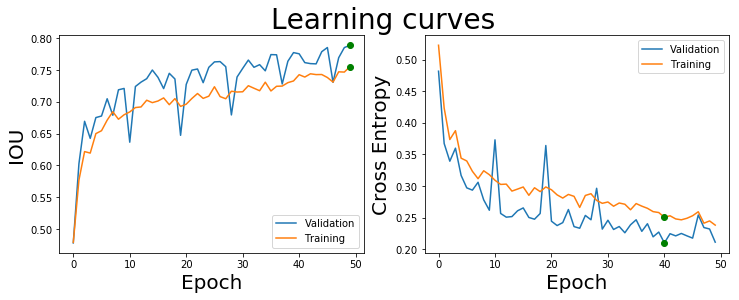

In [7]:
plt.rcParams['figure.figsize'] = (12, 4) # Hacer las figuras más grandes

BestIOU = np.argmax(h.history['val_IOU_calc'])
plt.subplot(1, 2, 1)
plt.plot(h.history['val_IOU_calc'], label='Validation')
plt.plot(h.history['IOU_calc'], label='Training')
plt.legend(loc='lower right')
plt.plot(BestIOU, h.history['val_IOU_calc'][BestIOU],'go')
plt.plot(BestIOU, h.history['IOU_calc'][BestIOU],'go')
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('IOU', fontsize=20)
plt.suptitle('Learning curves', fontsize=28)

plt.subplot(1, 2, 2)
BestCE = np.argmin(h.history['val_loss'])
plt.plot(h.history['val_loss'], label='Validation')
plt.plot(h.history['loss'], label='Training')
plt.legend(loc='upper right')
plt.plot(BestCE, h.history['val_loss'][BestCE],'go')
plt.plot(BestCE, h.history['loss'][BestCE],'go')
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Cross Entropy', fontsize=20)

plt.savefig(RsltDir + '\\IOU_CE_' + FileName + '.png', bbox_inches='tight')
plt.show()

In [8]:
TrainScore = model.evaluate_generator(train_generator, steps=89//batch_size)
ValidationScore = model.evaluate_generator(validation_generator, steps=89//batch_size)
file = open(RsltDir + '\\BestModelAssess_' + FileName + '.txt', 'w') 
file.write('Training\n')
for Value in TrainScore:
    file.write(str(Value) + '\n') 
file.write('Validation\n')
for Value in ValidationScore:
    file.write(str(Value) + '\n')
file.close()
print('Model assess saved')

Model assess saved
